# Stats about frequency of functions in the train and test programs
In this notebook I plan to gain an overview of the operations contained in the LOGO domain programs.
1) Which python operations are contained beside the primitive functions specified in the REGAL paper?
2) Does the embed(prog, vars) which I view as indicator of subprograms is contained in all programs? Is it contained more then once in some programs and if so how often?
3) What is the frequency of the other functions occuring in programs?

In [1]:
import json
import pandas as pd
import ast
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /home/pratz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining needed functions to answer question 1 to 3.

In [2]:
def is_primitive(name, primitives):
    """Check if a function name is a primitive."""
    return name in primitives

def visit_node(node, primitives, expressions=None, function=None):
    """Recursively visit AST nodes to extract relevant expressions or count the specified function."""
    count = 0
    if isinstance(node, ast.Call):
        # Handle function calls
        if isinstance(node.func, ast.Name):
            if expressions is not None and not is_primitive(node.func.id, primitives):
                expressions.add(node.func.id)
            if function is not None and node.func.id == function:
                count += 1

    elif isinstance(node, ast.For):
        # Extract 'for'-loop construct
        if expressions is not None:
            expressions.add("for-loop")
        if function and "for-loop" in function:
            count += 1

    # Recursively visit child nodes
    for child in ast.iter_child_nodes(node):
        count += visit_node(child, primitives, expressions, function)
    
    return count

def extract_non_logo_expressions(data, primitives):
    """
    Extracts non-pimitive expressions from programs identified by the 'gpt' key in the dataset.

    Args:
        data (list): List of dictionaries containing the human description of the results of the program as well as the program itself.
        primitives (list): List of primitives to exclude.

    Returns:
        list: List of unique non-primitive expressions.
    """
    expressions = set()

    # Iterate over each dictionary in the dataset
    for item in data:
        if 'program' in item:
            code = item['program']
            try:
                tree = ast.parse(code)
                visit_node(tree, primitives, expressions=expressions)
            except SyntaxError:
                continue

        else:
            for message in item.get('messages', []):
                if message['from'] == 'gpt':
                    code = message['value']
                    try:
                        tree = ast.parse(code)
                        visit_node(tree, primitives, expressions=expressions)
                    except SyntaxError:
                        continue

    return list(expressions)

def count_functions_frequency(data, functions):
    """
    Counts the frequency of programs containing a specific operation (a function or for-loop).

    Args:
        data (list): List of dictionaries containing the human description of the results of the program as well as the program itself.
        function (str): The function name to count in the dataset.

    Returns:
        dict: A dictionary with the count of programs containing the specified function.
    """
    frequency_count = {}

    # Iterate over each dictionary in the dataset
    for item in data:
        if 'program' in item:
            code = item['program']
            try:
                tree = ast.parse(code)
                count = visit_node(tree, primitives=[], function=functions)
                if count in frequency_count:
                    frequency_count[count] += 1
                else:
                    frequency_count[count] = 1
            except SyntaxError:
                continue

        for message in item.get('messages', []):
            if message['from'] == 'gpt':
                code = message['value']
                try:
                    tree = ast.parse(code)
                    count = visit_node(tree, primitives=[], function=functions)
                    if count in frequency_count:
                        frequency_count[count] += 1
                    else:
                        frequency_count[count] = 1
                except SyntaxError:
                    continue

    return frequency_count

## LOGO
### Question 1: Py-operations beside LOGO primitives

In [3]:
#LOGO
train_logo_data = "logo_data/python/train_200_dataset.jsonl"
test_logo_data = "logo_data/python/test_dataset.jsonl"

# Load train and test dataset
with open(f"external/dependencies/{train_logo_data}", 'r') as f:
    train_data = [json.loads(line) for line in f]

with open(f"external/dependencies/{test_logo_data}", 'r') as f:
    test_data = [json.loads(line) for line in f]

In [4]:
# List containing LOGO primitives from the ReGAL paper
logo_primitives = ['forward', 'left', 'right', 'penup', 'pendown', 'teleport', 'heading', 'isdown', 'embed']

In [5]:
train_result = extract_non_logo_expressions(train_data, logo_primitives)
test_result = extract_non_logo_expressions(test_data, logo_primitives)

print(train_result)
print(test_result)

['locals', 'for-loop', 'range']
['locals', 'for-loop', 'range']


### Question 2 and 3: Frequency of functions in programs

In [ ]:
# Count the frequency of programs containing LOGO-functions and python-functions
def display_frequency(data, functions_list):
    for function in functions_list:
        function_frequency = count_functions_frequency(data, function)
        df = pd.DataFrame(list(function_frequency.items()), columns=["Frequency of function", "Frequency of Programs"]).sort_values(by="Frequency of function")
        df.set_index("Frequency of function", inplace=True)
        print(f"Frequency Table for '{function}':")
        print(df)
        print("-" * 50)

print("Python-functions:")
print("Train data:")
display_frequency(train_data, train_result)
print("Test data:")
display_frequency(test_data, test_result)

print("\n")
print("\n")
print("Logo-primitives:")
print("Train data:")
display_frequency(train_data, logo_primitives)
print("Test data:")
display_frequency(test_data, logo_primitives)

Python-functions:
Train data:
Frequency Table for 'locals':
                       Frequency of Programs
Frequency of function                       
0                                         64
1                                        136
--------------------------------------------------
Frequency Table for 'for-loop':
                       Frequency of Programs
Frequency of function                       
1                                        159
2                                         19
3                                         22
--------------------------------------------------
Frequency Table for 'range':
                       Frequency of Programs
Frequency of function                       
1                                        159
2                                         19
3                                         22
--------------------------------------------------
Test data:
Frequency Table for 'locals':
                       Frequency of Programs
Frequency 

### Observations:
in train and test:
left occurse multiple times right never

teleport, heading, isdown never occures 

### Detect dublicate entries in the train and test data

In [7]:
# Extract descriptions and programs from train_data and transform into pandas DataFrame
def extract_descriptions_and_programs(data):
    extracted_data = []
    for item in data:
        description = None
        program = None
        for message in item.get('messages', []):
            if message['from'] == 'human':
                description = message['value']
            elif message['from'] == 'gpt':
                program = message['value']
        if description and program:
            extracted_data.append([description, program])
    extracted_data = pd.DataFrame(extracted_data, columns=['Description', 'Program'])
    return extracted_data

# Extract descriptions and programs from train_data
df_train = extract_descriptions_and_programs(train_data)
df_test = extract_descriptions_and_programs(test_data)

#display(df_train)
#display(df_test)

# Append the test data to the train data
df_all = pd.concat([df_train, df_test], ignore_index=True)
#display(df_all)

#####################
# Create a list of row indices where the same description reappears
df_all['Description Repeats'] = df_all['Description'].map(lambda desc: [i for i, d in enumerate(df_all['Description']) if d == desc])
df_all['Program Repeats'] = df_all['Program'].map(lambda code: [i for i, c in enumerate(df_all['Program']) if c == code])
#####################

#####################
# Drop all duplicate rows
df_all = df_all.drop_duplicates(subset=['Description', 'Program'])
#display(df_all)
#####################

#####################
# Check if the row indices collected for the description and program are the same
df_all['Same Index'] = df_all.apply(lambda row: row['Description Repeats'] == row['Program Repeats'], axis=1)

# Filter and print the rows where 'Same Index' is False
#print(df_all['Same Index'].value_counts())
display(df_all[df_all['Same Index'] == False])
#####################

#####################
# Add columns for the count of description repeats and program repeats
df_all['n-Times Desc. Repeated'] = df_all['Description Repeats'].map(len)
df_all['n-Times Prog. Repeated'] = df_all['Program Repeats'].map(len)
#####################

# Drop all rows where 'n-Times Prog. Repeated' and 'n-Times Desc. Repeated' are both 1
#df_all = df_all[~((df_all['n-Times Prog. Repeated'] == 1) & (df_all['n-Times Desc. Repeated'] == 1))]

# Display the updated DataFrame
display(df_all)
print(df_all['n-Times Desc. Repeated'].value_counts())
print(df_all['n-Times Prog. Repeated'].value_counts())

#print(df_all['Description'].value_counts())
#print(df_all['Program'].value_counts())


,Description,Program,Description Repeats,Program Repeats,Same Index
43,5 sided snowflake with a short line and a smal...,"for j in range(5):\n embed(""""""penup()\nforw...",[43],"[43, 287]",False
287,5 sided snowflake with a short space and a sho...,"for j in range(5):\n embed(""""""penup()\nforw...",[287],"[43, 287]",False


,Description,Program,Description Repeats,Program Repeats,Same Index,n-Times Desc. Repeated,n-Times Prog. Repeated
0,4 concentric square s,"for i in range(5):\n embed(""""""for j in rang...","[0, 34, 80, 103, 180, 183]","[0, 34, 80, 103, 180, 183]",True,6,6
1,6 sided snowflake with a medium line and a med...,"for j in range(6):\n embed(""""""forward(8)\nl...",[1],[1],True,1,1
2,5 sided snowflake with a medium line and a sma...,"for j in range(5):\n embed(""""""forward(8)\nl...",[2],[2],True,1,1
3,6 short line s in a row,"for j in range(6):\n embed(""""""forward(2)\nl...","[3, 113, 118, 164]","[3, 113, 118, 164]",True,4,4
4,a small triangle connected by a big line to a ...,for i in range(3):\n forward(2)\n left(1...,[4],[4],True,1,1
...,...,...,...,...,...,...,...
306,8 sided snowflake with a medium circle and a s...,"for j in range(8):\n embed(""""""penup()\nforw...",[306],[306],True,1,1
307,5 sided snowflake with 2 small circle s as arms,"for j in range(5):\n embed(""""""penup()\nforw...",[307],[307],True,1,1
308,3 sided snowflake with a small square and a sm...,"for j in range(3):\n embed(""""""penup()\nforw...",[308],[308],True,1,1
309,5 sided snowflake with a small 5 gon and a sma...,"for j in range(5):\n embed(""""""penup()\nforw...",[309],[309],True,1,1


n-Times Desc. Repeated
1    237
2     16
3      6
4      3
6      2
Name: count, dtype: int64
n-Times Prog. Repeated
1    235
2     18
3      6
4      3
6      2
Name: count, dtype: int64


There is a total of 263 unique programs (235+(18-1)+6+3+2; one program is twice in the list because it has two different descriptions, therefore 18-1) and there are 264 unique program descriptions. Some programs and descriptions appear up to six times in the data. 

In [16]:
# Function to check if a program is in both train and test data (in df_all all indexes below and equal to 200 are train data, and everything above is test data)
def program_is_in_train_and_test(lst):
    above_200 = any(x > 200 for x in lst)
    below_200 = any(x <= 200 for x in lst)
    return above_200 and below_200

# there is one data which is repeated in both train and test data: Why? probably because there are two different descriptions for the same program 
df_all['Prog in Train and Test']=df_all['Program Repeats'].apply(program_is_in_train_and_test)
display(df_all[df_all['Prog in Train and Test'] == True])

2


,Description,Program,Description Repeats,Program Repeats,Same Index,n-Times Desc. Repeated,n-Times Prog. Repeated,Prog in Train and Test
43,5 sided snowflake with a short line and a smal...,"for j in range(5):\n embed(""""""penup()\nforw...",[43],"[43, 287]",False,1,2,True
287,5 sided snowflake with a short space and a sho...,"for j in range(5):\n embed(""""""penup()\nforw...",[287],"[43, 287]",False,1,2,True


### Investigate the kind of shapes and sizes occuring in the programs

Using the human descriptions of the programs an overview is created indicating which shapes are drawn, in what sizes if so and how many sides the shapes have if it applies.

In [5]:
#OVERVIEW: of the terms used in the descriptions
def get_unique_words(column):
    unique_words = set()
    for description in column:
        # Split by spaces and remove punctuation
        words = description.lower().replace(",", "").replace(".", "").split()
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        unique_words.update(words)
    return unique_words

unique_words = get_unique_words(df_all["Description"])
print(unique_words)

{'big', 'medium', '2', 'arms', 'circle', 'sided', '4', 'snowflake', 'turns', 'greek', 'connected', '3', 'row', '5', 'stepped', 'star', 'square', 'spiral', 'semicircle', '8', 'pointed', 'next', 'line', 'small', 'triangle', 'zigzag', 'short', 'gon', 'concentric', '9', '7', '6', 'space', 'separated', 'staircase'}


In [6]:
import re

# Def. dictionaries
shapes_dict = {
    "line": "line",
    "triangle": "triangle",
    "square": "square",
    "5 gon": "pentagon",
    "6 gon": "hexagon",
    "7 gon": "heptagon",
    "8 gon": "octagon",
    "9 gon": "nonagon",
    "circle": "circle",
    "semicircle": "semicircle",
    "spiral": "greek-spiral",
    "star": "star",
    "snowflake": "snowflake",
    # not directly gemoetric shapes but patterns created from lines
    "staircase": "staircase",
    "zigzag": "zigzag",
    # absence of a shape which has size descriptions
    "space": "space"
}

sizes_dict = {
    "short": "short",
    "small": "small",
    "medium": "medium",
    "big": "big"
}

shape_attributes_dict = {
    "row": "row",             # describes repeating shapes in a row applies to basic shapes (line -> semicircle)
    "concetric": "concetric", # describes circles & squares
    "turns": "turns",         # describes the number of turns in a greek-spiral 
    "stepped": "stepped",     # describes a staircase and zigzag pattern
    "pointed": "pointed",     # describes a star
    # describes only snowflake
    "sided": "sided",
    "arms": "arms"
}

relationship_dict = {
    "separated": "separated",
    "connected": "connected",
    "next": "next"
}

In [7]:
# Parsing the description to extract shapes, sizes and sides and determine if it is a main shape or an arm-shape
# (Drawback of this parsing function is that it does not retrive the information how often a shape is repeated)
def parse_description(description):
    result = {}
    shape_count = 0
    arm_count = 0

    # Extract all potential shape matches
    shapes_pattern = r"(small|medium|big|short)?\s*(\d+)?\s*(?:sided)?\s*(line|triangle|square|[5-9] gon|circle|semicircle|spiral|star|snowflake|staircase|zigzag|space)" 

    # define how an arm shape is identified
    arm_shape_pattern1 = r"(?:with a|with \d+)\s*" + shapes_pattern # either by prefix 
    arm_shape_pattern2 = shapes_pattern + r"?\s*as arms"            # or by suffix

    main_shapes_matches = re.findall(shapes_pattern, description)
    arm_shapes_matches1 = re.findall(arm_shape_pattern1, description)
    arm_shapes_matches2 = re.findall(arm_shape_pattern2, description)
    #print("Main Shapes Matches:", main_shapes_matches) # Debugging
    #print("Arm Shapes Matches1:", arm_shapes_matches1) # Debugging
    #print("Arm Shapes Matches2:", arm_shapes_matches2) # Debugging

    arm_shapes_matches = arm_shapes_matches1 + arm_shapes_matches2
    arm_shapes_matches_unique = list({match: None for match in arm_shapes_matches}.keys()) # remove duplicates which have been identifeid by both thier pre- and suffix
    main_shapes_matches = [match for match in main_shapes_matches if match not in arm_shapes_matches_unique] # remove arm shapes from main shapes
    #print("Main Shapes:",  main_shapes_matches) # Debugging
    #print("Arm Shapes:", arm_shapes_matches_unique) # Debugging
    
    for match in main_shapes_matches:
        size, side, shape = match  # Unpacking the 3 groups
        size = size.strip() if size else None
        side = int(side) if side else None
        standardized_shape = shapes_dict.get(shape.strip(), shape.strip())
        if not standardized_shape:
            continue  # Skip unrecognized shapes or already processed snowflakes

        shape_count += 1
        result[f"shape{shape_count}"] = {
            "shape": standardized_shape,
            "size": sizes_dict.get(size, None),
            "side": side
        }

    for match in arm_shapes_matches_unique:
        size, side, shape = match
        size = size.strip() if size else None
        side = int(side) if side else None
        standardized_shape = shapes_dict.get(shape.strip(), shape.strip())
        if not standardized_shape:
            continue

        arm_count += 1
        result[f"arm{arm_count}"] = {
            "shape": standardized_shape,
            "size": sizes_dict.get(size, None),
            "side": side
        }

    return result

In [9]:
#Test usage
example_df = pd.DataFrame({
    "Description": [
        "a small triangle connected by a big line to a medium circle",
        "7 sided snowflake with a 6 sided snowflake as arms which has a medium square as arms",
        "a small greek spiral",
        "6 sided snowflake with a small 5 gon and a small square as arms",
        "5 sided snowflake with 2 small circle s as arms"
    ]
})
# Apply the parsing function
example_df["Parsed"]=example_df["Description"].apply(parse_description)
parsed_df = example_df["Parsed"].apply(pd.Series)

# Sort columns first all columns which start with shape then with arm and drop parsed
sorted_columns = sorted([col for col in parsed_df.columns if col.startswith('shape')]) + sorted([col for col in parsed_df.columns if col.startswith('arm')])
result_df = pd.concat([example_df, parsed_df], axis=1)
result_df = result_df[['Description'] + sorted_columns]
display(result_df)

,Description,shape1,shape2,shape3,arm1,arm2
0,a small triangle connected by a big line to a ...,"{'shape': 'triangle', 'size': 'small', 'side':...","{'shape': 'line', 'size': 'big', 'side': None}","{'shape': 'circle', 'size': 'medium', 'side': ...",NaN,NaN
1,7 sided snowflake with a 6 sided snowflake as ...,"{'shape': 'snowflake', 'size': None, 'side': 7}",NaN,NaN,"{'shape': 'snowflake', 'size': None, 'side': 6}","{'shape': 'square', 'size': 'medium', 'side': ..."
2,a small greek spiral,"{'shape': 'greek-spiral', 'size': None, 'side'...",NaN,NaN,NaN,NaN
3,6 sided snowflake with a small 5 gon and a sma...,"{'shape': 'snowflake', 'size': None, 'side': 6}",NaN,NaN,"{'shape': 'pentagon', 'size': 'small', 'side':...","{'shape': 'square', 'size': 'small', 'side': N..."
4,5 sided snowflake with 2 small circle s as arms,"{'shape': 'snowflake', 'size': None, 'side': 5}",NaN,NaN,"{'shape': 'circle', 'size': 'small', 'side': N...",NaN


In [8]:
# Apply the parsing function
df_all["Parsed"]=df_all["Description"].apply(parse_description)
parsed_df = df_all["Parsed"].apply(pd.Series)

# Sort columns first all columns which start with shape then with arm and drop parsed
sorted_columns = sorted([col for col in parsed_df.columns if col.startswith('shape')]) + sorted([col for col in parsed_df.columns if col.startswith('arm')])
result_df = pd.concat([df_all, parsed_df], axis=1)
result_df = result_df[['Description'] + sorted_columns]
#result_df = pd.concat([result_df, df_all["Program"]], axis=1)

display(result_df)

,Description,shape1,shape2,shape3,arm1,arm2
0,4 concentric square s,"{'shape': 'square', 'size': None, 'side': None}",NaN,NaN,NaN,NaN
1,6 sided snowflake with a medium line and a med...,"{'shape': 'snowflake', 'size': None, 'side': 6}",NaN,NaN,"{'shape': 'line', 'size': 'medium', 'side': None}","{'shape': 'pentagon', 'size': 'medium', 'side'..."
2,5 sided snowflake with a medium line and a sma...,"{'shape': 'snowflake', 'size': None, 'side': 5}",NaN,NaN,"{'shape': 'line', 'size': 'medium', 'side': None}","{'shape': 'octagon', 'size': 'small', 'side': ..."
3,6 short line s in a row,"{'shape': 'line', 'size': 'short', 'side': None}",NaN,NaN,NaN,NaN
4,a small triangle connected by a big line to a ...,"{'shape': 'triangle', 'size': 'small', 'side':...","{'shape': 'line', 'size': 'big', 'side': None}","{'shape': 'circle', 'size': 'medium', 'side': ...",NaN,NaN
...,...,...,...,...,...,...
306,8 sided snowflake with a medium circle and a s...,"{'shape': 'snowflake', 'size': None, 'side': 8}",NaN,NaN,"{'shape': 'circle', 'size': 'medium', 'side': ...","{'shape': 'circle', 'size': 'small', 'side': N..."
307,5 sided snowflake with 2 small circle s as arms,"{'shape': 'snowflake', 'size': None, 'side': 5}",NaN,NaN,"{'shape': 'circle', 'size': 'small', 'side': N...",NaN
308,3 sided snowflake with a small square and a sm...,"{'shape': 'snowflake', 'size': None, 'side': 3}",NaN,NaN,"{'shape': 'square', 'size': 'small', 'side': N...","{'shape': 'circle', 'size': 'small', 'side': N..."
309,5 sided snowflake with a small 5 gon and a sma...,"{'shape': 'snowflake', 'size': None, 'side': 5}",NaN,NaN,"{'shape': 'pentagon', 'size': 'small', 'side':...","{'shape': 'square', 'size': 'small', 'side': N..."


In [9]:
print(result_df.iloc[1]['Description'])
print(result_df.iloc[1]['shape1'])

print(result_df.iloc[260]['Description'])
print(result_df.iloc[260]['shape1'])
print(result_df.iloc[260]['arm1'])

print(result_df.iloc[263]['Description'])
print(result_df.iloc[263]['shape1'])

6 sided snowflake with a medium line and a medium 5 gon as arms
{'shape': 'snowflake', 'size': None, 'side': 6}
5 sided snowflake with 2 small circle s as arms
{'shape': 'snowflake', 'size': None, 'side': 5}
{'shape': 'circle', 'size': 'small', 'side': None}
6 sided snowflake with a small 5 gon and a small square as arms
{'shape': 'snowflake', 'size': None, 'side': 6}


In [11]:
def count_attribute_occurrences(data, attribute, columns):
    """
    Count the occurrences of a specific attribute (shape, size, or side) in the specified columns.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        attribute (str): The attribute to count ('shape', 'size', or 'side').
        columns (list): The list of columns to search for the attribute.

    Returns:
        pd.DataFrame: A DataFrame containing the count of occurrences for each attribute value.
    """
    attribute_counts = {}

    for col in columns:
        for attribute_info in data[col]:
            if isinstance(attribute_info, dict):
                attr_value = attribute_info.get(attribute)
                if attr_value:
                    if attr_value in attribute_counts:
                        attribute_counts[attr_value] += 1
                    else:
                        attribute_counts[attr_value] = 1

    # Convert the counts to a DataFrame for better visualization
    attribute_counts_df = pd.DataFrame(list(attribute_counts.items()), columns=[attribute.capitalize(), 'Count']).sort_values(by='Count', ascending=False)

    # Add a row for the total sum of all counts
    total_sum = attribute_counts_df['Count'].sum()
    total_row = pd.DataFrame({attribute.capitalize(): ['Total'], 'Count': [total_sum]})
    attribute_counts_df = pd.concat([attribute_counts_df, total_row], ignore_index=True)
    
    return attribute_counts_df

# Example usage
columns_overall = result_df.columns[result_df.columns.get_loc('shape1'):]
columns_arms = result_df.columns[result_df.columns.get_loc('arm1'):]

shape_overall_counts_df = count_attribute_occurrences(result_df, 'shape', columns_overall)
shape_arms_counts_df = count_attribute_occurrences(result_df, 'shape', columns_arms)
shape_counts_df = shape_overall_counts_df.merge(shape_arms_counts_df, on='Shape', how='left', suffixes=('_Overall', '_Arms')).fillna(0)

size_overall_counts_df = count_attribute_occurrences(result_df, 'size', columns_overall)
size_arms_counts_df = count_attribute_occurrences(result_df, 'size', columns_arms)
size_counts_df = size_overall_counts_df.merge(size_arms_counts_df, on='Size', how='left', suffixes=('_Overall', '_Arms')).fillna(0)

side_counts_df = count_attribute_occurrences(result_df, 'side', columns_overall)


display(shape_counts_df)
display(size_counts_df)
display(side_counts_df)

,Shape,Count_Overall,Count_Arms
0,snowflake,147,0.0
1,line,100,42.0
2,circle,73,34.0
3,space,71,56.0
4,semicircle,64,36.0
5,square,49,26.0
6,pentagon,45,26.0
7,triangle,37,22.0
8,octagon,17,8.0
9,heptagon,16,6.0


,Size,Count_Overall,Count_Arms
0,small,191,111.0
1,medium,164,91.0
2,short,91,60.0
3,big,29,0.0
4,Total,475,262.0


,Side,Count
0,8,36
1,3,34
2,6,33
3,7,22
4,5,22
5,Total,147


In [12]:
columns = result_df.columns[result_df.columns.get_loc('shape1'):]

# Function to extract the x-y combinations from a given row
def extract_shape_size(row, x, y, columns):
    shapes = []
    
    # Iterate over columns extract x-y pairs
    for col in columns:
        shape_info = row[col]
        if isinstance(shape_info, dict) and shape_info.get(x) and shape_info.get(y):
            shapes.append((shape_info[x], shape_info[y]))
    
    return shapes

def my_pivot_table(data, x, y, columns):
    # Apply the function to each row and extract x-y pairs
    shape_size_pairs = data.apply(lambda row: extract_shape_size(row, x, y, columns), axis=1)

    # Flatten the list of x-y pairs
    flat_pairs = []
    for row in shape_size_pairs:
        flat_pairs.extend(row)

    # Create a frequency table
    freq_table = pd.DataFrame(flat_pairs, columns=[x, y])

    # Create a pivot table with x as rows and y as columns, and the count of occurrences as values
    pivot_table = pd.pivot_table(freq_table, index=x, columns=y, aggfunc='size', fill_value=0)

    # Add an aggregated count column by summing the counts across sizes for each shape
    pivot_table['Total'] = pivot_table.sum(axis=1)

    # Display the result
    return pivot_table

# Apply the function to the DataFrame
display(my_pivot_table(result_df, 'shape', 'size', columns))
display(my_pivot_table(result_df, 'shape', 'size', ['shape1', 'shape2', 'shape3']))
display(my_pivot_table(result_df, 'shape', 'size', ['arm1', 'arm2']))

display(my_pivot_table(result_df, 'shape', 'side', columns))

# Note:
# some shapes (e.g. star, spiral, zigzag, staircase) are not shown in these tables, because they are neither big, small, short, medium nor have a number of sides

size,big,medium,short,small,Total
shape,,,,,
circle,0,35,0,31,66
heptagon,0,0,0,16,16
hexagon,0,0,0,8,8
line,14,35,51,0,100
nonagon,0,0,0,8,8
octagon,0,1,0,16,17
pentagon,0,13,0,32,45
semicircle,0,37,0,27,64
space,15,16,40,0,71


size,big,medium,short,small,Total
shape,,,,,
circle,0,19,0,13,32
heptagon,0,0,0,10,10
hexagon,0,0,0,5,5
line,14,13,31,0,58
nonagon,0,0,0,5,5
octagon,0,1,0,8,9
pentagon,0,7,0,12,19
semicircle,0,18,0,10,28
space,15,0,0,0,15


size,medium,short,small,Total
shape,,,,
circle,16,0,18,34
heptagon,0,0,6,6
hexagon,0,0,3,3
line,22,20,0,42
nonagon,0,0,3,3
octagon,0,0,8,8
pentagon,6,0,20,26
semicircle,19,0,17,36
space,16,40,0,56


side,3,5,6,7,8,Total
shape,,,,,,
snowflake,34,22,33,22,36,147


#### Looking into the programs

In [14]:
print(pd.api.types.is_string_dtype(df_all['Program']))
print(df_all['Description'].iloc[0])
print(df_all['Program'].iloc[0])

True
4 concentric square s
for i in range(5):
    embed("""for j in range(4):
    forward(2*i)
    left(90.0)""", locals())


In [10]:
def extract_range(program):
    # Extract the range from the program
    range_pattern = r"range\((\d+|HALF_INF)\)"
    range_match = re.findall(range_pattern, program)
    return range_match


def count_range_frequencies(ranges):
        range_counts = {}
        for range_list in ranges:
            for digit in range_list:
                if digit in range_counts:
                    range_counts[digit] += 1
                else:
                    range_counts[digit] = 1
        
        range_counts = dict(sorted(range_counts.items()))
        return range_counts



# Apply the function to the DataFrame
ranges =df_all['Program'].apply(extract_range)
count_range_frequencies(ranges)

# Count the frequency of the extracted range digits
range_frequencies = count_range_frequencies(ranges)
print(range_frequencies)

{'3': 81, '4': 60, '5': 78, '6': 51, '7': 43, '8': 57, '9': 11, 'HALF_INF': 213}


#### Calculate Semantic Length of Programs

In [11]:
# TEST
# contain an embed function with one for-loop # Expect 100
test_prog_0=df_all['Program'].iloc[2]

# contain no embed function # Expect 12
test_prog_1='for j in range(2):\n    forward(8*i)\n    left(51.42857142857143)\n    forward(EPS_DIST*1)\n    penup()\n    forward(EPS_DIST*1)\n    pendown()\n'

# containing two consecutive (4 small full circles) # Expect 
test_prog_2="for j in range(5):\n    embed(\"\"\"penup()\nforward(2)\nleft(0.0)\n\npendown()\nfor i in range(HALF_INF):\n    forward(EPS_DIST*2)\n    left(EPS_ANGLE)\nfor i in range(HALF_INF):\n    forward(EPS_DIST*2)\n    left(EPS_ANGLE)\npenup()\nforward(2)\nleft(0.0)\n\npendown()\nfor i in range(HALF_INF):\n    forward(EPS_DIST*2)\n    left(EPS_ANGLE)\"\"\", locals())\n    forward(0)\n    left(72.0)\n"

# containing two consecutive embed functions # Expect 200
test_prog_3='for j in range(5):\n    embed("""forward(8)\nleft(0.0)\nfor i in range(8):\n    forward(2)\n    left(45.0)""", locals())\n    forward(0)\n    left(72.0)\n embed("""forward(3)\nleft(0.0)\nfor i in range(8):\n    forward(2)\n    left(45.0)""", locals())\n forward(1)\n    left(12.0)\n'

# containing two consecutive for-loops in embed function # Expect 740
test_prog_4='for j in range(5):\n    embed("""forward(8)\nleft(0.0)\nfor i in range(8):\n    forward(2)\n    left(45.0)\n for i in range(8):\n    forward(2)\n    left(45.0)""", locals())\n forward(1)\n    left(12.0)\n'

print(test_prog_0)

for j in range(5):
    embed("""forward(8)
left(0.0)
for i in range(8):
    forward(2)
    left(45.0)""", locals())
    forward(0)
    left(72.0)



In [12]:
def calc_semantic_length(program):
    output = []
    stack = [] # Stack to manage nested counts
    
    # Regex patterns for the entire input
    for_loop_pattern = r"for\s+\w+\s+in\s+range\((\d+|HALF_INF)\):" # add the option of HALF_INF which is used to draw simicircles and circles
    embed_start_pattern = r'embed\("""'
    forward_left_pattern = r"(forward|left|right|penup|pendown|teleport|heading|isdown)\(([\w\.\*\+\-\(\)0-9]*)\)"
    embed_end_pattern = r'""", locals\(\)\)'
    
    # Track position in input
    position = 0
    while position < len(program):
        # Match for-loop
        for_match = re.match(for_loop_pattern, program[position:])
        if for_match:
            loop_value = for_match.group(1)  # Extract the loop value (either a digit or HALF_INF)
            if loop_value == "HALF_INF":  # If the loop is using HALF_INF
                output.append(f"180*(")  # Append 180 for HALF_INF
            else:
                n_iter = int(loop_value)  # Convert the loop value to an integer if it's a digit
                output.append(f"{n_iter}*(")
            stack.append(0)  # track for-loop
            position += for_match.end()
            continue
        
        # Match embed start
        embed_start_match = re.match(embed_start_pattern, program[position:])
        if embed_start_match:
            output.append("(")
            stack.append(1)  # track embed block
            position += embed_start_match.end()
            continue
        
        # Match forward/left
        forward_left_match = re.match(forward_left_pattern, program[position:])
        if forward_left_match:
            # Check if the last character in output is a closing bracket
            if output and re.search(r"\)+$", output[-1]):
                output.append("+1+")  # Append "+1+" if there are closing brackets
            else:
                output.append("1+")  # Otherwise, append "1+"
            #if stack:
            #    stack[-1] += 1  # Increment the counter for the current block
            position += forward_left_match.end()
            continue
        
        # Match embed end
        embed_end_match = re.match(embed_end_pattern, program[position:])
        count_zeros = 0
        if embed_end_match:
            if stack:
                for i in reversed(range(len(stack))):
                    if stack[i] == 1:
                        count_zeros +=1
                        break
                    elif stack[i] == 0:
                        count_zeros +=1
                stack = stack[:i] # remove all the last elements since starting the embed block
                if output and output[-1] == "1+":
                    output[-1] = "1"
                output.append(")" * count_zeros)

                #count = 0 # set the count to 0 after adding brackets
            position += embed_end_match.end()
            continue
        
        # Increment position if no match is found
        position += 1
    
    # Close any remaining loops
    while stack:
        count = int(len(stack))
        stack = [] # clear the stack
        if output and output[-1] == "1+":
            output[-1] = "1"
        output.append(")"* count) 
   
    # Combine the output
    result = ''.join(output).rstrip('+')
    #print(f"Formular: {result}") # If you want to see the Formular underlying the Semantic Calculation
    try:
        result = eval(result)
    except Exception as e:
        print(f"Error while evaluation the expression: {e}")
    
    return result

# Testing
pseudo_program = test_prog_4
print(pseudo_program)
parsed_output = calc_semantic_length(pseudo_program)
print(parsed_output)

for j in range(5):
    embed("""forward(8)
left(0.0)
for i in range(8):
    forward(2)
    left(45.0)
 for i in range(8):
    forward(2)
    left(45.0)""", locals())
 forward(1)
    left(12.0)

740


In [13]:
df_all['Semantic Length'] = df_all['Program'].apply(calc_semantic_length)
display(df_all)

,Description,Program,Description Repeats,Program Repeats,Same Index,n-Times Desc. Repeated,n-Times Prog. Repeated,Parsed,Semantic Length
0,4 concentric square s,"for i in range(5):\n embed(""""""for j in rang...","[0, 34, 80, 103, 180, 183]","[0, 34, 80, 103, 180, 183]",True,6,6,"{'shape1': {'shape': 'square', 'size': None, '...",40
1,6 sided snowflake with a medium line and a med...,"for j in range(6):\n embed(""""""forward(8)\nl...",[1],[1],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",84
2,5 sided snowflake with a medium line and a sma...,"for j in range(5):\n embed(""""""forward(8)\nl...",[2],[2],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",100
3,6 short line s in a row,"for j in range(6):\n embed(""""""forward(2)\nl...","[3, 113, 118, 164]","[3, 113, 118, 164]",True,4,4,"{'shape1': {'shape': 'line', 'size': 'short', ...",36
4,a small triangle connected by a big line to a ...,for i in range(3):\n forward(2)\n left(1...,[4],[4],True,1,1,"{'shape1': {'shape': 'triangle', 'size': 'smal...",195492
...,...,...,...,...,...,...,...,...,...
306,8 sided snowflake with a medium circle and a s...,"for j in range(8):\n embed(""""""penup()\nforw...",[306],[306],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",16891030128
307,5 sided snowflake with 2 small circle s as arms,"for j in range(5):\n embed(""""""penup()\nforw...",[307],[307],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",10556893830
308,3 sided snowflake with a small square and a sm...,"for j in range(3):\n embed(""""""penup()\nforw...",[308],[308],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",782010
309,5 sided snowflake with a small 5 gon and a sma...,"for j in range(5):\n embed(""""""penup()\nforw...",[309],[309],True,1,1,"{'shape1': {'shape': 'snowflake', 'size': None...",380


count    2.640000e+02
mean     1.053045e+08
std      1.223731e+09
min      7.000000e+00
25%      6.300000e+01
50%      1.520000e+02
75%      1.955025e+05
max      1.689103e+10
Name: Semantic Length, dtype: float64


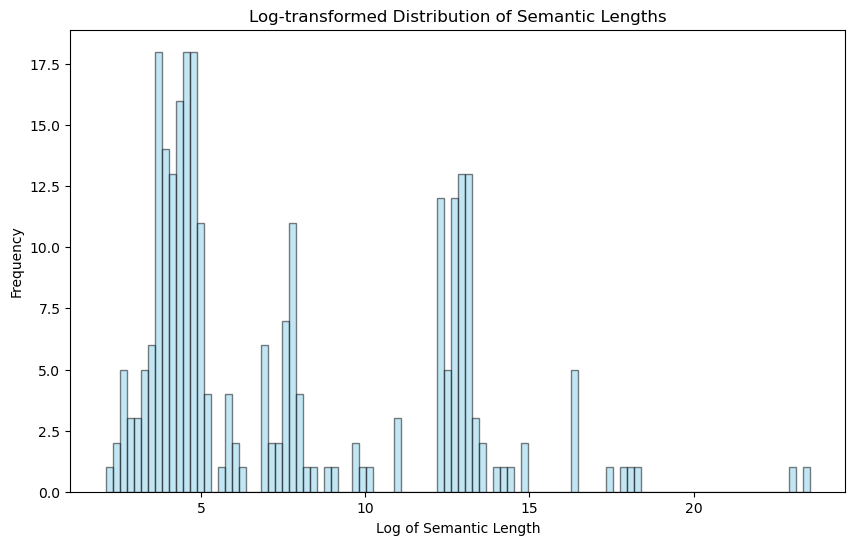

In [14]:
# Visualization of the semantic length distribution
print(df_all['Semantic Length'].describe())

import matplotlib.pyplot as plt
import numpy as np

# Apply log transformation to 'Semantic Length' to compress the range
log_semantic_length = np.log1p(df_all['Semantic Length'])  # log1p handles zero values too

# Create a graph of the log-transformed semantic length frequencies
plt.figure(figsize=(10, 6))
plt.hist(log_semantic_length, bins=100, alpha=0.5, stacked=True, color='skyblue', edgecolor='black')
plt.xlabel('Log of Semantic Length')
plt.ylabel('Frequency')
plt.title('Log-transformed Distribution of Semantic Lengths')
plt.show()

## TextCraft

In [8]:
#TextCraft
train_textcraft_data = "python_data/textcraft/gpt-4/train.jsonl"
test_textcraft_data = "python_data/textcraft/gpt-4/test_d2.jsonl"

# Load train and test dataset
with open(f"external/dependencies/{train_textcraft_data}", 'r') as f:
    train_data = [json.loads(line) for line in f]

with open(f"external/dependencies/{test_textcraft_data}", 'r') as f:
    test_data = [json.loads(line) for line in f]                        # here is no program key therfore empty results 

In [9]:
# List containing TextCraft primitives from the ReGAL paper
primitives = ['get_object', 'craft_object', 'check_inventory']
train_result = extract_non_logo_expressions(train_data, primitives)
test_result = extract_non_logo_expressions(test_data, primitives)

print(train_result)
print(test_result)

[]
[]


In [10]:
# Count the frequency of programs containing the 'embed' function
def display_frequency(data, functions_list):
    for function in functions_list:
        function_frequency = count_functions_frequency(data, function)
        df = pd.DataFrame(list(function_frequency.items()), columns=["Frequency of function", "Frequency of Programs"]).sort_values(by="Frequency of function")
        df.set_index("Frequency of function", inplace=True)
        print(f"Frequency Table for '{function}':")
        print(df)
        print("-" * 50)


print("Logo-primitives:")
print("Train data:")
display_frequency(train_data, primitives)
print("Test data:")
display_frequency(test_data, primitives)

Logo-primitives:
Train data:
Frequency Table for 'get_object':
                       Frequency of Programs
Frequency of function                       
1                                         50
2                                         69
3                                         48
4                                         15
5                                          2
6                                          5
--------------------------------------------------
Frequency Table for 'craft_object':
                       Frequency of Programs
Frequency of function                       
2                                         64
3                                         69
4                                         26
5                                         12
6                                          7
7                                          7
8                                          3
10                                         1
----------------------------------------